# Ray et al 2013 Benchmarking 
**Authorship:**
Adam Klie, *09/03/2022*
***
**Description:**
Notebook to benchmark MT and ST models against trained DeepBind models
***

In [121]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import logging
import numpy as np
import pandas as pd
import eugene as eu

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene/ray13"
eu.settings.output_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/ray13"
eu.settings.logging_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/ray13"
eu.settings.config_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/configs/ray13"
figure_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/figures/ray13"
eu.settings.verbosity = logging.ERROR

# Performances from Alipanahi et al

In [3]:
sheet_name = ["Pearson of E-scores",
              "Spearman of E-scores",
              "Pearson of AUCs",
              "Spearman of AUCs",
              "Pearson of Z-scores",
              "Spearman of Z-scores",
              "Pearson with Intensities",
              "Spearman with intensities"]
performance_df = pd.DataFrame()
for sheet in sheet_name:
    x = pd.read_excel(os.path.join(eu.settings.dataset_dir, "41587_2015_BFnbt3300_MOESM53_ESM.xlsx"), sheet_name=sheet, skiprows=1, index_col=0)
    x["Metric"] = sheet.split(" ")[2]
    x["Correlation"] = sheet.split(" ")[0]
    x["Metric"] = x["Metric"].replace({"intensities": "Intensities"})
    x = x.rename({"Intensities": "Observed intensities", "MatrixREDUE": "MatrixREDUCE"}, axis=1)
    performance_df = pd.concat([performance_df, x], axis=0)

performance_summary = performance_df.melt(id_vars=["Correlation", "Metric"], var_name="Method", value_name="Value")

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  


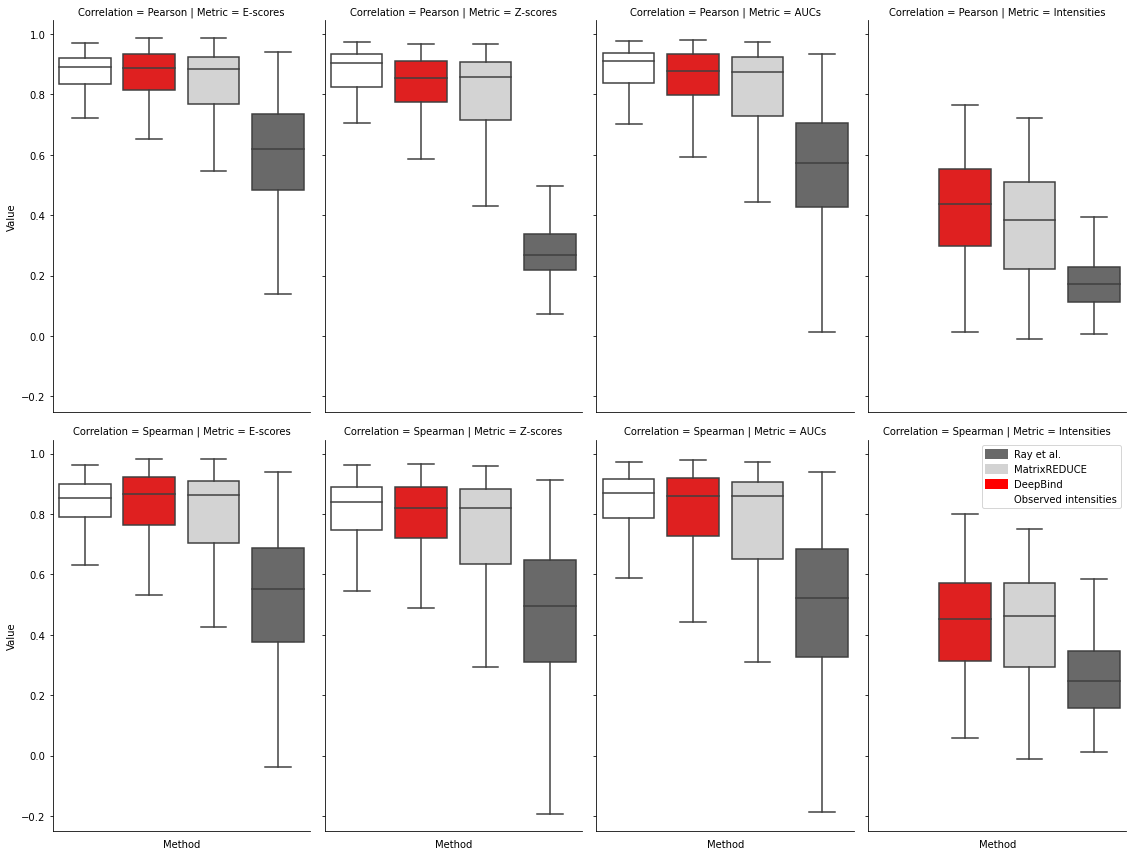

In [5]:
my_pal = {"Ray et al.": "dimgrey", "MatrixREDUCE": "lightgrey", "DeepBind": "red", "Observed intensities": "white"}
order = ["Observed intensities", "DeepBind", "MatrixREDUCE", "Ray et al."]
g = sns.FacetGrid(
    performance_summary, 
    row="Correlation", 
    col="Metric", 
    row_order=["Pearson", "Spearman"], 
    col_order=["E-scores", 
               "Z-scores", 
               "AUCs", 
               "Intensities"],
    height=6,
    aspect=0.66
)
g.map(sns.boxplot, "Method", "Value", palette=my_pal, order=order, showfliers = False)
patches = [matplotlib.patches.Patch(color=v, label=k, edgecolor="k", linewidth=3) for k,v in my_pal.items()]
plt.legend(handles=patches)
g.set(xticks=[])
g.fig.tight_layout()

# Performances from EUGENe

In [107]:
n_kmers = 100
pearson_long = pd.DataFrame()
spearman_long = pd.DataFrame()
for method in ["setA", "ST", "MT", "kipoi"]:
    x_pearson = pd.read_csv(os.path.join(eu.settings.output_dir, f"pearson_performance_{n_kmers}kmers_{method}.tsv"), sep="\t")
    pearson_long = pd.concat([pearson_long, x_pearson], axis=0)
    
    x_spearman = pd.read_csv(os.path.join(eu.settings.output_dir, f"spearman_performance_{n_kmers}kmers_{method}.tsv"), sep="\t")
    spearman_long = pd.concat([spearman_long, x_spearman], axis=0)

In [108]:
spearman_df = spearman_long.pivot(index=['RBP', 'Metric'], columns='Model', values='Spearman').reset_index()
spearman_df["Correlation"] = "Spearman"

In [109]:
pearson_df = pearson_long.pivot(index=['RBP', 'Metric'], columns='Model', values='Pearson').reset_index()
pearson_df["Correlation"] = "Pearson"

In [110]:
trained_perfromance_df = pd.concat([pearson_df, spearman_df], axis=0)

In [111]:
trained_perfromance_df["Metric"] = trained_perfromance_df["Metric"].replace({"Z-score":"Z-scores", "AUC":"AUCs", "E-score":"E-scores", "Intensity": "Intensities"})

In [112]:
trained_perfromance_df.head()

Model,RBP,Metric,Kipoi,MultiTask,SetA,SingleTask,Correlation
0,RNCMPT00001,AUCs,0.883468,0.829257,0.897752,0.873521,Pearson
1,RNCMPT00001,E-scores,0.878494,0.803550,0.877300,0.869286,Pearson
2,RNCMPT00001,Intensities,0.551630,0.524309,NaN,0.440124,Pearson
3,RNCMPT00001,Z-scores,0.802555,0.815662,0.886684,0.840576,Pearson
4,RNCMPT00002,AUCs,0.781111,0.716341,0.768744,0.775754,Pearson


In [113]:
paper_performance_df = performance_df.reset_index().rename({"index": "RBP"}, axis=1)
paper_performance_df.head()

,RBP,Observed intensities,DeepBind,MatrixREDUCE,Ray et al.,Metric,Correlation
0,RNCMPT00001,0.897,0.871,0.892,0.332,E-scores,Pearson
1,RNCMPT00002,0.810,0.761,0.795,0.365,E-scores,Pearson
2,RNCMPT00003,0.908,0.669,0.716,0.741,E-scores,Pearson
3,RNCMPT00004,0.942,0.957,0.959,0.729,E-scores,Pearson
4,RNCMPT00005,0.936,0.940,0.934,0.869,E-scores,Pearson


In [114]:
len(paper_performance_df), len(trained_perfromance_df)

(1952, 1952)

In [115]:
full_performance_df = pd.merge(trained_perfromance_df, paper_performance_df, on=["RBP", "Metric", "Correlation"]).set_index("RBP")

In [116]:
full_performance_summary = full_performance_df.melt(id_vars=["Correlation", "Metric"], var_name="Method", value_name="Value")

In [117]:
full_performance_summary

,Correlation,Metric,Method,Value
0,Pearson,AUCs,Kipoi,0.883468
1,Pearson,E-scores,Kipoi,0.878494
2,Pearson,Intensities,Kipoi,0.551630
3,Pearson,Z-scores,Kipoi,0.802555
4,Pearson,AUCs,Kipoi,0.781111
...,...,...,...,...
15611,Spearman,Z-scores,Ray et al.,0.577000
15612,Spearman,AUCs,Ray et al.,0.140000
15613,Spearman,E-scores,Ray et al.,0.141000
15614,Spearman,Intensities,Ray et al.,0.225000


# Performance boxplot

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  app.launch_new_instance()


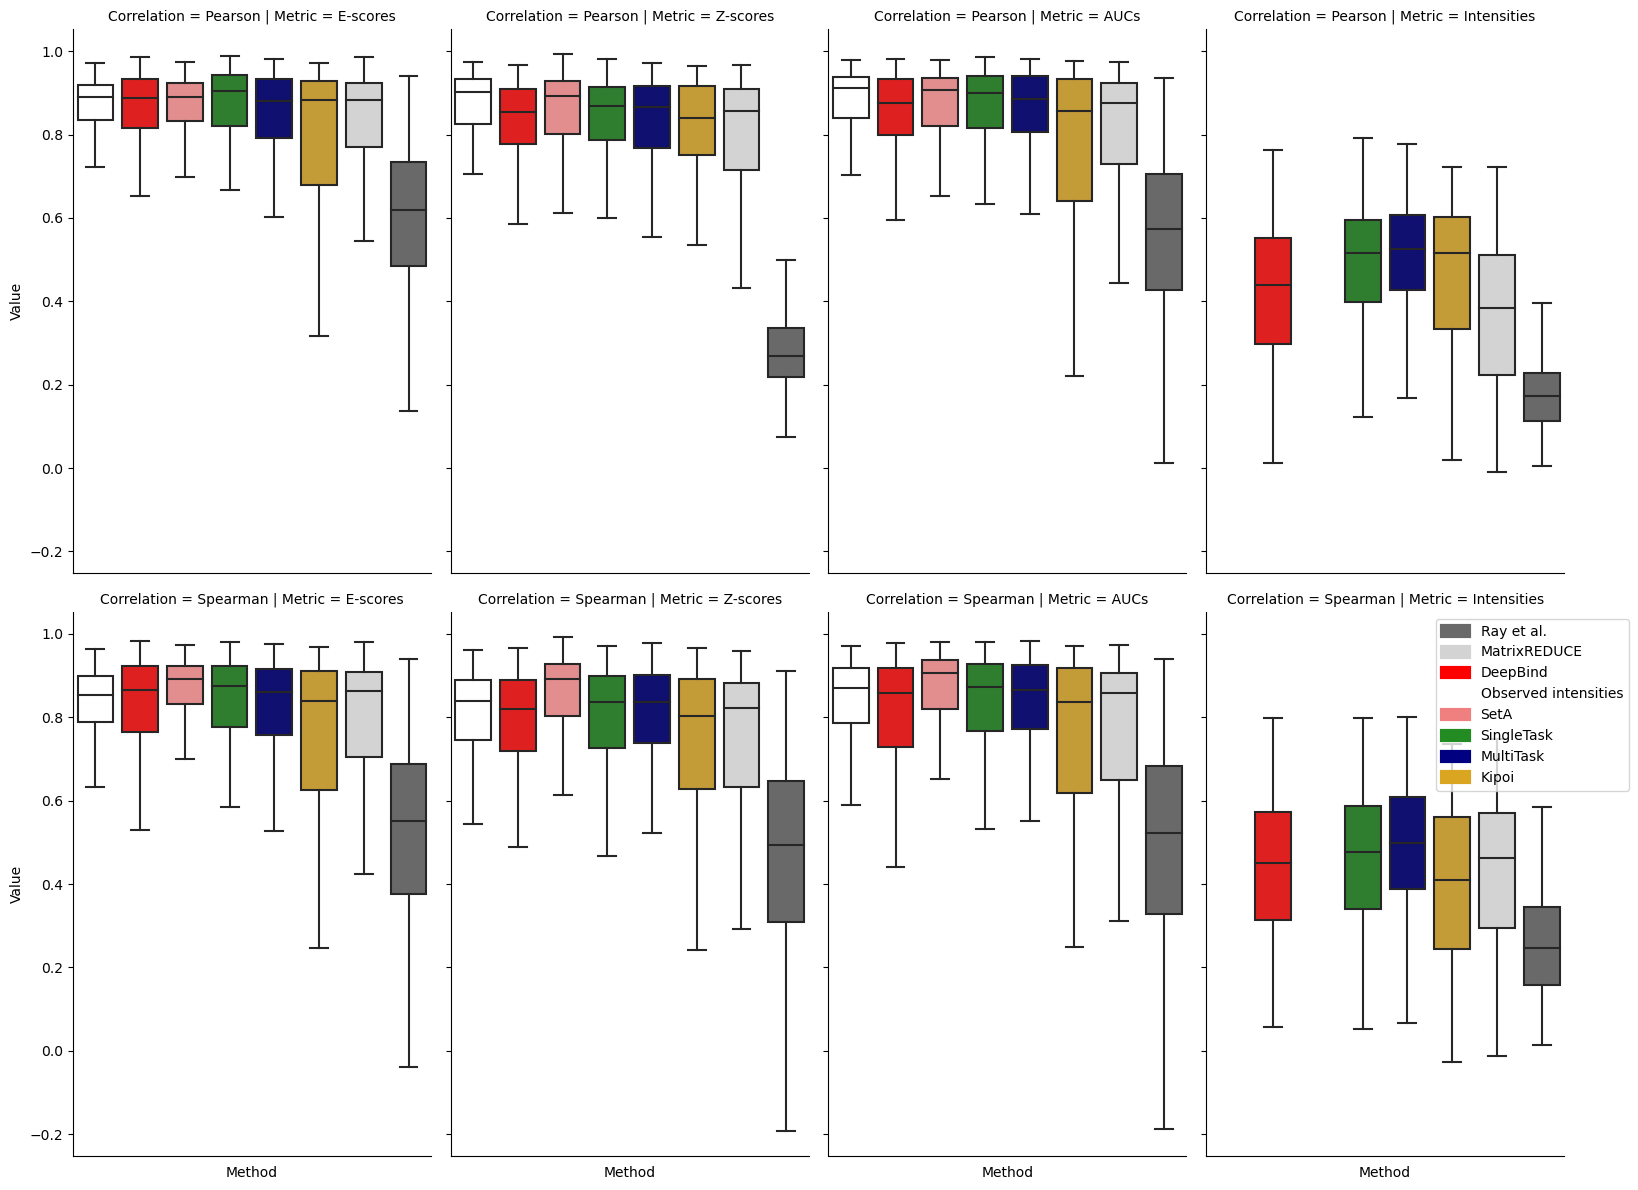

In [125]:
my_pal = {"Ray et al.": "dimgrey", "MatrixREDUCE": "lightgrey", "DeepBind": "red", "Observed intensities": "white",
         "SetA": "lightcoral", "SingleTask": "forestgreen", "MultiTask": "navy", "Kipoi": "goldenrod"}
order = ["Observed intensities", "DeepBind", "SetA", "SingleTask", "MultiTask", "Kipoi", "MatrixREDUCE", "Ray et al."]
g = sns.FacetGrid(
    full_performance_summary, 
    row="Correlation", 
    col="Metric", 
    row_order=["Pearson", "Spearman"], 
    col_order=["E-scores", 
               "Z-scores", 
               "AUCs", 
               "Intensities"],
    height=6,
    aspect=0.66
)
g.map(sns.boxplot, "Method", "Value", palette=my_pal, order=order, showfliers = False)
patches = [matplotlib.patches.Patch(color=v, label=k, edgecolor="k", linewidth=3) for k,v in my_pal.items()]
g.set(xticks=[])
g.fig.tight_layout()
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1));
plt.savefig(os.path.join(figure_dir, "correlation_boxplots_100kmers_all.pdf"))

## Comparison scatterplots

In [132]:
# Helper function to plot the a line to apply to FacetGrid
def const_line(*args, **kwargs):
    x = np.arange(0, 1.01, 0.01)
    plt.plot(x, x, c='dimgrey', ls='--')

[('Observed intensities', 'DeepBind'),
 ('Observed intensities', 'SetA'),
 ('Observed intensities', 'SingleTask'),
 ('Observed intensities', 'MultiTask'),
 ('Observed intensities', 'Kipoi'),
 ('Observed intensities', 'MatrixREDUCE'),
 ('Observed intensities', 'Ray et al.'),
 ('DeepBind', 'SetA'),
 ('DeepBind', 'SingleTask'),
 ('DeepBind', 'MultiTask'),
 ('DeepBind', 'Kipoi'),
 ('DeepBind', 'MatrixREDUCE'),
 ('DeepBind', 'Ray et al.'),
 ('SetA', 'SingleTask'),
 ('SetA', 'MultiTask'),
 ('SetA', 'Kipoi'),
 ('SetA', 'MatrixREDUCE'),
 ('SetA', 'Ray et al.'),
 ('SingleTask', 'MultiTask'),
 ('SingleTask', 'Kipoi'),
 ('SingleTask', 'MatrixREDUCE'),
 ('SingleTask', 'Ray et al.'),
 ('MultiTask', 'Kipoi'),
 ('MultiTask', 'MatrixREDUCE'),
 ('MultiTask', 'Ray et al.'),
 ('Kipoi', 'MatrixREDUCE'),
 ('Kipoi', 'Ray et al.'),
 ('MatrixREDUCE', 'Ray et al.')]

In [145]:
import itertools
for method_x, method_y in list(itertools.combinations(order, 2)):
    g = sns.FacetGrid(full_performance_df, col="Metric", col_order=["Z-scores", "AUCs", "E-scores", "Intensities"])
    g.map(sns.scatterplot, method_x, method_y, s=10, color="royalblue", alpha=0.75, edgecolor="k", linewidth=0.3)
    g.map(const_line)
    plt.savefig(os.path.join(figure_dir, "scatterplot_comparisons", f"model_pearson_scatterplot_comparisons_{method_x}_{method_y}.pdf"))
    plt.close()

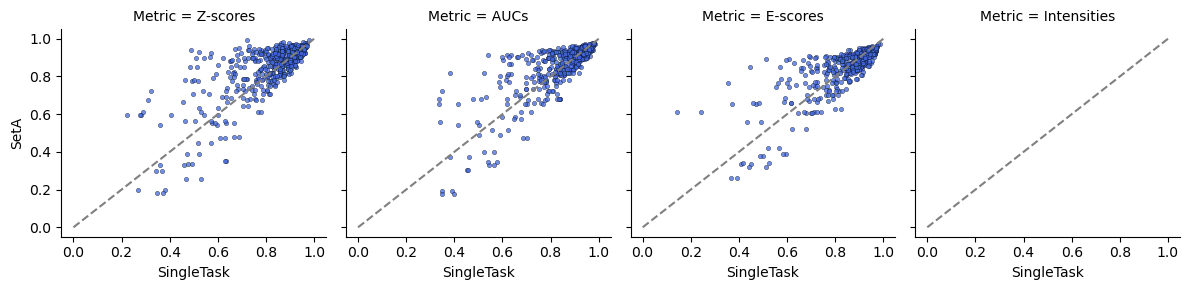

In [140]:
# Plot the evaluation metrics comparisons for single task vs SetA Pearson correlation
g = sns.FacetGrid(full_performance_df, col="Metric", col_order=["Z-scores", "AUCs", "E-scores", "Intensities"])
g.map(sns.scatterplot, "SingleTask", "SetA", s=10, color="royalblue", alpha=0.75, edgecolor="k", linewidth=0.3)
g.map(const_line)
plt.savefig(os.path.join(figure_dir, "model_pearson_scatterplot_comparisons_ST_setA_.pdf"))

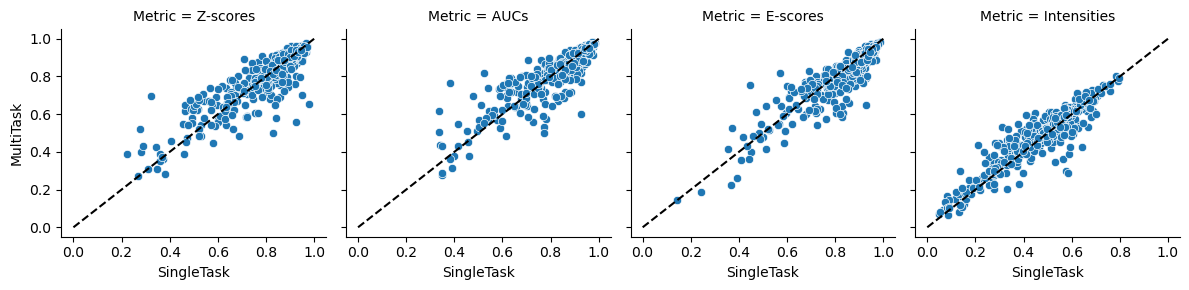

In [104]:
# Plot the evaluation metrics comparisons for single task vs SetA Pearson correlation
g = sns.FacetGrid(full_performance_df, col="Metric", col_order=["Z-scores", "AUCs", "E-scores", "Intensities"])
g.map(sns.scatterplot, "SingleTask", "MultiTask", s=10, color="royalblue", alpha=0.75, edgecolor="k", linewidth=0.3)
g.map(const_line)
#plt.savefig(os.path.join(figure_dir, "model_pearson_scatterplot_comparisons_ST_setA_.pdf"))

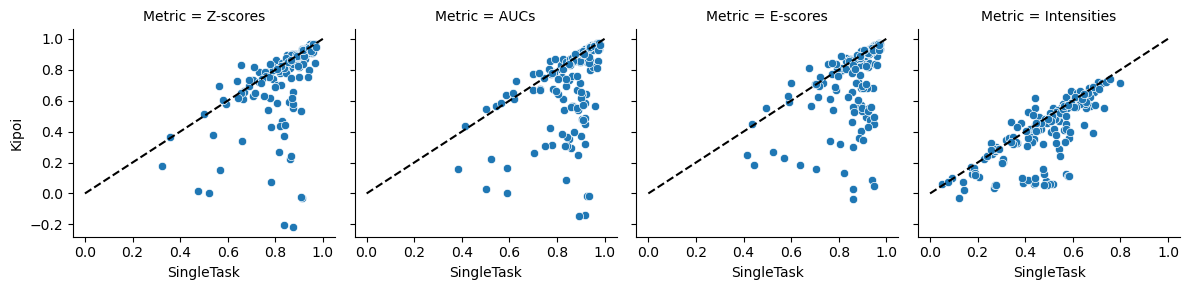

In [105]:
# Plot the evaluation metrics comparisons for single task vs SetA Pearson correlation
g = sns.FacetGrid(full_performance_df, col="Metric", col_order=["Z-scores", "AUCs", "E-scores", "Intensities"])
g.map(sns.scatterplot, "SingleTask", "Kipoi")
g.map(const_line)
#plt.savefig(os.path.join(figure_dir, "model_pearson_scatterplot_comparisons_ST_setA_.pdf"))

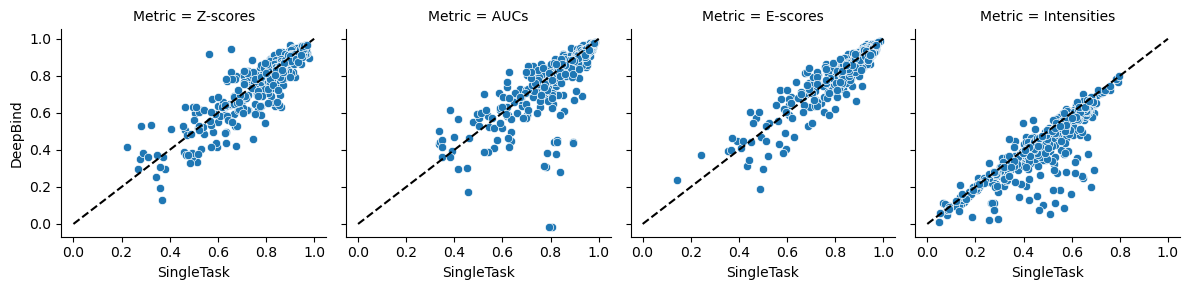

In [106]:
# Plot the evaluation metrics comparisons for single task vs SetA Pearson correlation
g = sns.FacetGrid(full_performance_df, col="Metric", col_order=["Z-scores", "AUCs", "E-scores", "Intensities"])
g.map(sns.scatterplot, "SingleTask", "DeepBind")
g.map(const_line)
#plt.savefig(os.path.join(figure_dir, "model_pearson_scatterplot_comparisons_ST_setA_.pdf"))

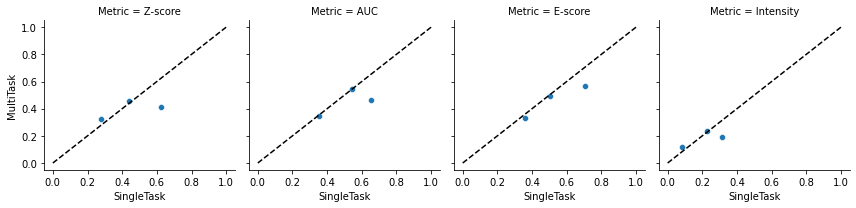

In [52]:
# Plot the evaluation metrics comparisons for single task vs multitask using Pearson correlation
g = sns.FacetGrid(pearson_models, col="Metric", col_order=["Z-score", "AUC", "E-score", "Intensity"])
g.map(sns.scatterplot, "SingleTask", "MultiTask")
g.map(const_line)
plt.savefig(os.path.join(figure_dir, "model_pearson_scatterplot_comparisons_ST_MT.pdf"))

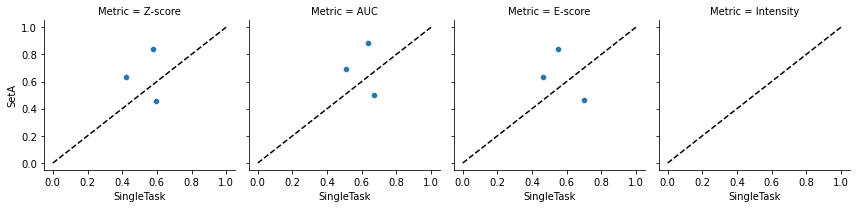

In [53]:
# Plot the evaluation metrics comparisons for single task vs SetA using Spearman correlation
g = sns.FacetGrid(spearman_models, col="Metric", col_order=["Z-score", "AUC", "E-score", "Intensity"])
g.map(sns.scatterplot, "SingleTask", "SetA")
g.map(const_line)
plt.savefig(os.path.join(figure_dir, "model_spearman_scatterplot_comparisons_ST_setA.pdf"))

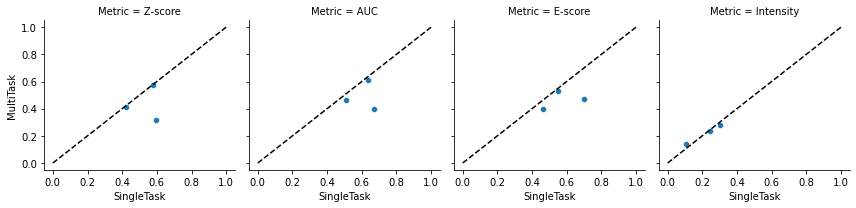

In [54]:
# Plot the evaluation metrics comparisons for single task vs multitask using Spearman correlation
g = sns.FacetGrid(spearman_models, col="Metric", col_order=["Z-score", "AUC", "E-score", "Intensity"])
g.map(sns.scatterplot, "SingleTask", "MultiTask")
g.map(const_line)
plt.savefig(os.path.join(figure_dir, "model_spearman_scatterplot_comparisons_ST_MT.pdf"))

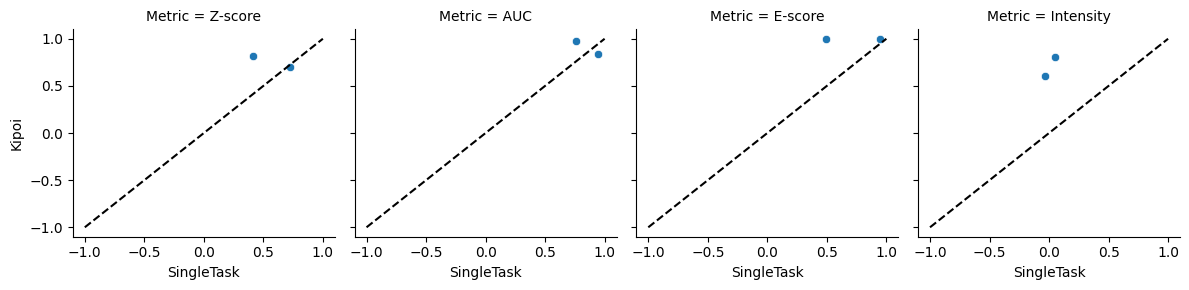

In [15]:
# Plot the Pearson correlations comparisons between single task vs kipoi
g = sns.FacetGrid(pearson_models, col="Metric", col_order=["Z-score", "AUC", "E-score", "Intensity"])
g.map(sns.scatterplot, "SingleTask", "Kipoi")
g.map(const_line)
plt.savefig(os.path.join(figure_dir, "model_pearson_scatterplot_comparisons_ST_kipoi.pdf"))

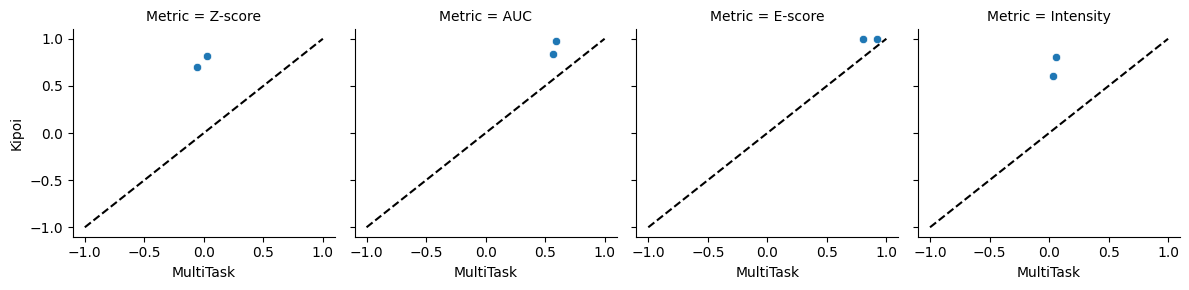

In [16]:
# Plot the Pearson correlations comparisons between multitask vs kipoi
g = sns.FacetGrid(pearson_models, col="Metric", col_order=["Z-score", "AUC", "E-score", "Intensity"])
g.map(sns.scatterplot, "MultiTask", "Kipoi")
g.map(const_line)
plt.savefig(os.path.join(figure_dir, "model_pearson_scatterplot_comparisons_MT_kipoi.pdf"))

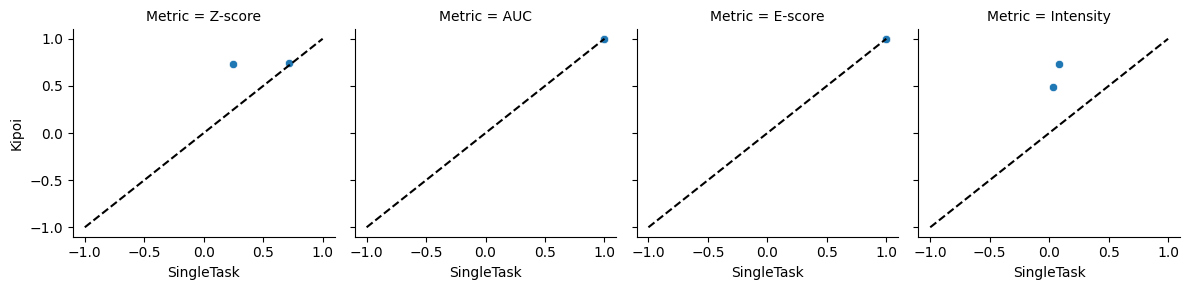

In [17]:
# Plot the Spearman correlations comparisons between single task vs kipoi
g = sns.FacetGrid(spearman_models, col="Metric", col_order=["Z-score", "AUC", "E-score", "Intensity"])
g.map(sns.scatterplot, "SingleTask", "Kipoi")
g.map(const_line)
plt.savefig(os.path.join(figure_dir, "model_spearman_scatterplot_comparisons_ST_kipoi.pdf"))

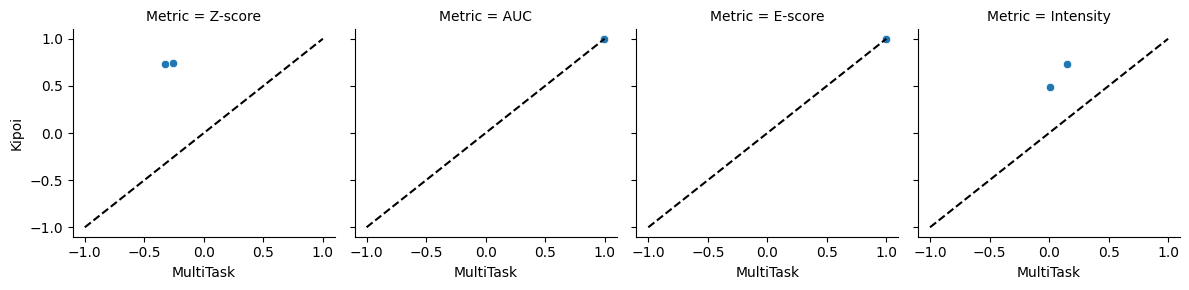

In [18]:
# Plot the Spearman correlations comparisons between multitask vs kipoi
g = sns.FacetGrid(spearman_models, col="Metric", col_order=["Z-score", "AUC", "E-score", "Intensity"])
g.map(sns.scatterplot, "MultiTask", "Kipoi")
g.map(const_line)
plt.savefig(os.path.join(figure_dir, "model_spearman_scatterplot_comparisons_MT_kipoi.pdf"))

---

# Scratch 

In [47]:
model = kipoi.get_model('DeepBind/Homo_sapiens/RBP/D00084.001_RNAcompete_A1CF').model
model.summary()

Using downloaded and verified file: /home/vscode/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00084.001_RNAcompete_A1CF/arch/127f7597630be937c0495a27e6f42e5f
Using downloaded and verified file: /home/vscode/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00084.001_RNAcompete_A1CF/weights/a4caf255312f44e3fd4e038a79691f2d
Model: "model_94"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_94 (InputLayer)          [(None, None, 4)]    0           []                               
                                                                                                  
 lambda_276 (Lambda)            (None, None, 4)      0           ['input_94[0][0]']               
                                                                                                  
 conv1d_94 (Conv1D)            

2022-09-04 00:29:07.587119: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open /home/vscode/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00084.001_RNAcompete_A1CF/weights/a4caf255312f44e3fd4e038a79691f2d: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


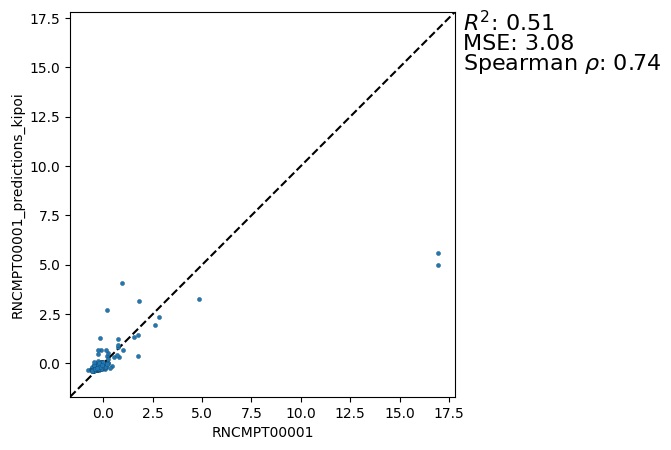

In [31]:
eu.pl.performance_scatter(
    sdata_test,
    target_cols[0],
    f"{target_cols[0]}_predictions_kipoi",
    figsize=(5, 5),
)

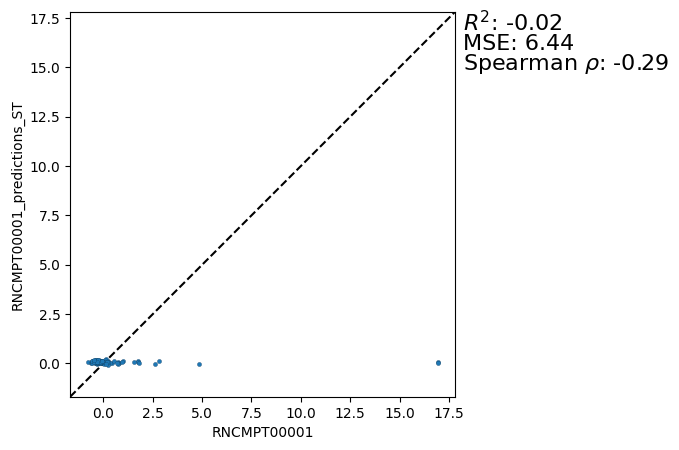

In [34]:
eu.pl.performance_scatter(
    sdata_test,
    target_cols[0],
    f"{target_cols[0]}_predictions_ST",
    figsize=(5, 5),
)

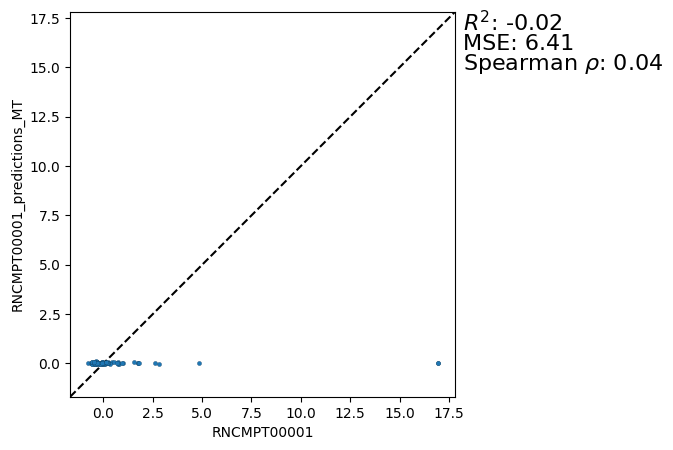

In [33]:
eu.pl.performance_scatter(
    sdata_test,
    target_cols[0],
    f"{target_cols[0]}_predictions_MT",
    figsize=(5, 5),
)

In [29]:
sdata_test

SeqData object with = 100 seqs
seqs = (100,)
names = (100,)
rev_seqs = None
ohe_seqs = (100, 41, 4)
ohe_rev_seqs = None
seqs_annot: 'Probe_Set', 'RNCMPT00001', 'RNCMPT00001_predictions_MT', 'RNCMPT00001_predictions_ST', 'RNCMPT00002', 'RNCMPT00002_predictions_MT', 'RNCMPT00002_predictions_ST', 'RNCMPT00003', 'RNCMPT00003_predictions_MT', 'RNCMPT00003_predictions_ST', 'RNCMPT00004', 'RNCMPT00004_predictions_MT', 'RNCMPT00004_predictions_ST', 'RNCMPT00005', 'RNCMPT00005_predictions_MT', 'RNCMPT00005_predictions_ST', 'RNCMPT00006', 'RNCMPT00006_predictions_MT', 'RNCMPT00007', 'RNCMPT00007_predictions_MT', 'RNCMPT00008', 'RNCMPT00009', 'RNCMPT00010', 'RNCMPT00010_predictions_MT', 'RNCMPT00011', 'RNCMPT00011_predictions_MT', 'RNCMPT00012', 'RNCMPT00012_predictions_MT', 'RNCMPT00013', 'RNCMPT00013_predictions_MT', 'RNCMPT00014', 'RNCMPT00014_predictions_MT', 'RNCMPT00015', 'RNCMPT00016', 'RNCMPT00016_predictions_MT', 'RNCMPT00017', 'RNCMPT00017_predictions_MT', 'RNCMPT00018', 'RNCMPT00018_pr

In [24]:
sdata_test["RNCMPT00001"].values

array([-3.27493065e-01, -3.42261224e-01,  1.93591734e-01,  1.73070340e+00,
       -8.22276870e-02, -3.87272678e-03, -8.00605627e-01,  7.51865532e-01,
       -1.84364492e-02, -1.90977154e-01, -6.11971428e-01,  1.69336841e+01,
       -1.50286938e-01,  4.15017634e-01, -3.44858715e-01,  8.02916737e-01,
       -8.69724004e-02, -2.55419595e-01,  2.21111708e-01, -2.52743450e-01,
        9.75111618e-01, -5.56894859e-01,  2.17765571e-01,  9.40233517e-01,
       -1.17495874e-01, -2.20792741e-01, -3.07698375e-01, -3.35112310e-01,
                   nan,  2.80191096e+00, -4.30429143e-01,  1.73595124e+00,
       -4.14881768e-01,  1.30148548e-01, -3.21330673e-02, -2.34298934e-01,
       -4.13446572e-01,  2.53961042e-02,  1.54145652e-01, -3.14702400e-01,
       -3.93914593e-01,  1.26059497e-01, -5.08499739e-01, -5.71038245e-01,
       -1.16288360e-01, -3.65702018e-01,  5.31071407e-02,  3.11713442e-01,
       -4.44369047e-01,  7.26077537e-01, -5.90690279e-02, -4.74033695e-01,
        5.54652000e-01, -